In [1]:
from functools import partial
from ISLP.models import (Stepwise,sklearn_selected,sklearn_selection_path)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
import itertools
import warnings

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ISLP
import sklearn.linear_model as skl
import sklearn.model_selection as skm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.pipeline import Pipeline
from ISLP.models import (ModelSpec as MS)
import seaborn as sns

# Question 8

## A & B

In [3]:
X=np.random.normal(size=100)*10
eps=np.random.normal(size=100)*0.10
pw=[np.power(X,i) for i in range(1,11)]
idx=[f'X_{i}' for i in range(1,11)]
df=pd.DataFrame(pw,index=idx).T
# X_sq=np.square(X)
# X_cu=X*np.square(X)
Y=-10+(10*X)+(4*df['X_2'])+(7*df['X_3'])+eps
df=pd.concat([df,pd.DataFrame(Y,columns=['Y'])],axis=1)
df

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,Y
0,4.886458,23.877470,116.676251,570.133578,2.785934e+03,1.361335e+04,6.652105e+04,3.250523e+05,1.588354e+06,7.761426e+06,951.113643
1,-4.514610,20.381707,-92.015469,415.413997,-1.875432e+03,8.466847e+03,-3.822451e+04,1.725688e+05,-7.790809e+05,3.517247e+06,-617.752111
2,10.228441,104.620996,1070.109644,10945.552900,1.119559e+05,1.145135e+06,1.171294e+07,1.198051e+08,1.225420e+09,1.253413e+10,8001.616354
3,-1.806853,3.264718,-5.898865,10.658382,-1.925813e+01,3.479661e+01,-6.287235e+01,1.136011e+02,-2.052605e+02,3.708755e+02,-56.226646
4,-18.318793,335.578193,-6147.387595,112612.723493,-2.062929e+06,3.779037e+07,-6.922741e+08,1.268163e+10,-2.323121e+11,4.255677e+12,-41882.439643
...,...,...,...,...,...,...,...,...,...,...,...
95,4.929246,24.297467,119.768193,590.366894,2.910064e+03,1.434442e+04,7.070718e+04,3.485331e+05,1.718005e+06,8.468471e+06,974.726493
96,-4.411324,19.459781,-85.843400,378.683062,-1.670494e+03,7.369089e+03,-3.250744e+04,1.434009e+05,-6.325877e+05,2.790549e+06,-577.156731
97,-11.950755,142.820551,-1706.813446,20397.709736,-2.437680e+05,2.913212e+06,-3.481509e+07,4.160666e+08,-4.972310e+09,5.942286e+10,-11505.929185
98,-7.034023,49.477484,-348.025775,2448.021413,-1.721944e+04,1.211219e+05,-8.519745e+05,5.992809e+06,-4.215356e+07,2.965091e+08,-2318.477251


## C

In [4]:
def get_neg_cp(sigma2,estimator,X,Y):
    n,p=X.shape
    Y_hat=estimator.predict(X)
    RSS=np.square(Y-Y_hat).sum()
    return -(RSS + 2*p*sigma2)/n    

In [5]:
design=MS(df.columns.drop('Y')).fit(df)
X=design.transform(df)
result=sm.OLS(Y,X).fit()
sigma2=result.scale
print(sigma2,design.terms)
neg_cp=partial(get_neg_cp,sigma2)

0.009474432017590389 Index(['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10'], dtype='object')


In [6]:
strategy=Stepwise.first_peak(design,direction='forward',max_terms=len(design.terms))
strategy

Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x0000023FD0CF2330>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10'], dtype='object'))>, check_finished=<function first_peak at 0x0000023FCD05FCE0>, postprocess=<function _postprocess_best at 0x0000023FCD05FF60>)

In [7]:
X

,intercept,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,1.0,4.886458,23.877470,116.676251,570.133578,2.785934e+03,1.361335e+04,6.652105e+04,3.250523e+05,1.588354e+06,7.761426e+06
1,1.0,-4.514610,20.381707,-92.015469,415.413997,-1.875432e+03,8.466847e+03,-3.822451e+04,1.725688e+05,-7.790809e+05,3.517247e+06
2,1.0,10.228441,104.620996,1070.109644,10945.552900,1.119559e+05,1.145135e+06,1.171294e+07,1.198051e+08,1.225420e+09,1.253413e+10
3,1.0,-1.806853,3.264718,-5.898865,10.658382,-1.925813e+01,3.479661e+01,-6.287235e+01,1.136011e+02,-2.052605e+02,3.708755e+02
4,1.0,-18.318793,335.578193,-6147.387595,112612.723493,-2.062929e+06,3.779037e+07,-6.922741e+08,1.268163e+10,-2.323121e+11,4.255677e+12
...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,4.929246,24.297467,119.768193,590.366894,2.910064e+03,1.434442e+04,7.070718e+04,3.485331e+05,1.718005e+06,8.468471e+06
96,1.0,-4.411324,19.459781,-85.843400,378.683062,-1.670494e+03,7.369089e+03,-3.250744e+04,1.434009e+05,-6.325877e+05,2.790549e+06
97,1.0,-11.950755,142.820551,-1706.813446,20397.709736,-2.437680e+05,2.913212e+06,-3.481509e+07,4.160666e+08,-4.972310e+09,5.942286e+10
98,1.0,-7.034023,49.477484,-348.025775,2448.021413,-1.721944e+04,1.211219e+05,-8.519745e+05,5.992809e+06,-4.215356e+07,2.965091e+08


In [8]:
df_cp=sklearn_selected(sm.OLS,strategy,scoring=neg_cp)
print(df_cp)
df_cp.fit(df,Y)
print(df_cp.selected_state_)

sklearn_selected(model_type=<class 'statsmodels.regression.linear_model.OLS'>,
                 scoring=functools.partial(<function get_neg_cp at 0x0000023FD0D656C0>, 0.009474432017590389),
                 strategy=Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x0000023FD0CF2330>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10'], dtype='object'))>, check_finished=<function first_peak at 0x0000023FCD05FCE0>, postprocess=<function _postprocess_best at 0x0000023FCD05FF60>))
('X_1', 'X_10', 'X_2', 'X_3')


## D

### Backward Selection 

In [9]:
X = df.drop(columns='Y')  
y = df['Y']
X = sm.add_constant(X)

# Fit the full model and get residuals
full_model = sm.OLS(y, X).fit()
sigma_squared = np.var(full_model.resid)
print(sigma_squared, full_model.scale)# Estimated variance of residuals

def calculate_cp(model, n, sigma_squared):
    rss = np.sum(model.resid**2)  # Residual Sum of Squares
    p = len(model.params)  # Number of parameters (including intercept)
    Cp = (rss + 2*p*sigma_squared)/n
    return Cp

def backward_stepwise_cp(X, y, sigma_squared, tolerance=0.1):
    n = len(y)
    prev_Cp = np.inf  # Start with an infinitely large Cp value
    
    while True:
        model = sm.OLS(y, X).fit()
        Cp = calculate_cp(model, n, sigma_squared)
        p = len(model.params)  # Number of parameters
        
        print(f"Mallows' Cp: {Cp}, Number of predictors (p): {p-1}")
        
        # Stop when Mallows' Cp is close to the number of predictors (p)
        if np.abs(Cp - p) < tolerance:
            print(f"Stopping as Cp ({Cp}) is close to the number of predictors (p={p}).")
            break
        
        # Get the p-values of the predictors
        p_values = model.pvalues
        # Get the predictor with the highest p-value
        max_p_value = p_values.max()
        
        # If no significant p-values to remove, stop
        if max_p_value > 0.05:
            excluded_predictor = p_values.idxmax()
            X = X.drop(columns=[excluded_predictor])
        else:
            break
    
    return X, model

# Perform backward elimination with Mallows' Cp stopping criterion
X_selected, final_model = backward_stepwise_cp(X, y, sigma_squared)

# Summary of the final model
print(final_model.summary())


0.008422687988779334 0.009474432017590389
Mallows' Cp: 0.010285235853186898, Number of predictors (p): 10
Mallows' Cp: 0.010088007111937018, Number of predictors (p): 9
Mallows' Cp: 0.01004690579375176, Number of predictors (p): 8
Mallows' Cp: 0.009928972896796682, Number of predictors (p): 7
Mallows' Cp: 0.009852739405562324, Number of predictors (p): 6
Mallows' Cp: 0.009746372956023392, Number of predictors (p): 5
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.450e+11
Date:                Sat, 28 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:15:44   Log-Likelihood:                 95.123
No. Observations:                 100   AIC:                            -178.2
Df Residuals:              

## (E) Lasso

In [10]:
design=MS(df.columns.drop('Y')).fit(df)
X=np.asarray(design.fit_transform(df).drop('intercept',axis=1))
X.shape

(100, 10)

In [11]:
K=5
kfold=skm.KFold(n_splits=K,shuffle=True,random_state=0)
lassoCV=skl.ElasticNetCV(l1_ratio=1,n_alphas=200,cv=kfold,verbose=0)
scaler=StandardScaler()
pipeCV=Pipeline(steps=[('scaler',scaler),('lassoCV',lassoCV)])
pipeCV.fit(X,Y)
tuned_lasso=pipeCV.named_steps['lassoCV']
tuned_lasso.alpha_,tuned_lasso.alphas,tuned_lasso.intercept_

(18.601392133373725, None, 2294.0045761159536)

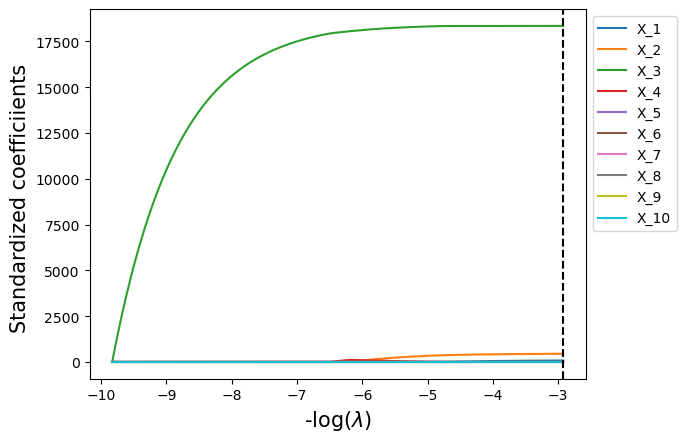

In [12]:
Xs=X-X.mean(0)
Xs=Xs/X.std(0)
lambdas,lasso_path,_=skl.Lasso.path(Xs,Y,l1_ratio=1,n_alphas=200)
lasso_plt,ax=plt.subplots()
soln_path=pd.DataFrame(lasso_path.T,columns=idx,index=-np.log(lambdas))
soln_path.plot(ax=ax)
ax.axvline(-np.log(tuned_lasso.alpha_),c='k',ls='--')
ax.set_xlabel(r'-log($\lambda)$', fontsize =15)
ax.set_ylabel('Standardized coefficiients ', fontsize =15)
plt.legend(loc='upper left',bbox_to_anchor=(1,1));

In [13]:
indx_lambda=np.where(np.round(lambdas,3)==(round(tuned_lasso.alpha_,3)))[0]
lasso_coeffs=lasso_path[:,indx_lambda]
lasso_coeffs.T,tuned_lasso.coef_,tuned_lasso.intercept_

(array([[   76.38495331,   445.10139873, 18348.07279493,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ]]),
 array([8.84201821e+01, 4.45176755e+02, 1.83193783e+04, 0.00000000e+00,
        1.81044255e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 2294.0045761159536)

In [14]:
'''CV MSE corresponding to each lambda'''
tuned_lasso.mse_path_.shape,tuned_lasso.mse_path_.mean(1)

((200, 5),
 array([3.35308658e+08, 3.27863948e+08, 3.20893200e+08, 3.09350233e+08,
        2.97046972e+08, 2.84264515e+08, 2.65269916e+08, 2.47547309e+08,
        2.31012570e+08, 2.15585239e+08, 2.01190562e+08, 1.87759721e+08,
        1.75228166e+08, 1.63535660e+08, 1.52625237e+08, 1.42445045e+08,
        1.32947022e+08, 1.24084057e+08, 1.15813292e+08, 1.08097464e+08,
        1.00896511e+08, 9.41779051e+07, 8.79088870e+07, 8.20592717e+07,
        7.66000581e+07, 7.15066000e+07, 6.67539337e+07, 6.23182445e+07,
        5.81797462e+07, 5.43172421e+07, 5.07135481e+07, 4.73500790e+07,
        4.42119847e+07, 4.12829743e+07, 3.85502319e+07, 3.59994664e+07,
        3.36196319e+07, 3.13981786e+07, 2.93256012e+07, 2.73908655e+07,
        2.55850522e+07, 2.39003733e+07, 2.23276770e+07, 2.08597078e+07,
        1.94902331e+07, 1.82117054e+07, 1.70182381e+07, 1.59042382e+07,
        1.48650313e+07, 1.38947663e+07, 1.29889782e+07, 1.21439981e+07,
        1.13549950e+07, 1.06183521e+07, 9.93064120e+0

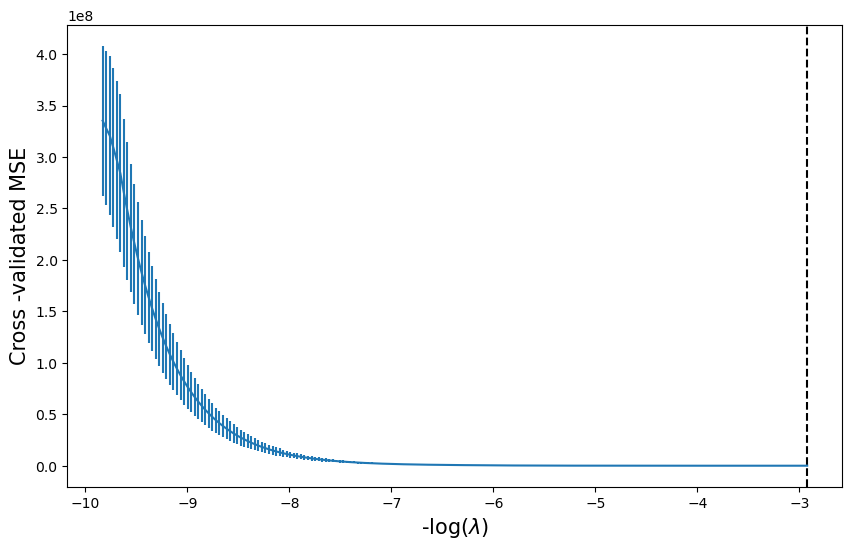

In [15]:
mse_cv,ax=plt.subplots(figsize=(10,6))
ax.errorbar(-np.log(tuned_lasso.alphas_),tuned_lasso.mse_path_.mean(1),
       yerr=tuned_lasso.mse_path_.std(1)/np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_),c='k',ls='--')
ax.set_xlabel(r'-log($\lambda)$', fontsize =15)
ax.set_ylabel('Cross -validated MSE', fontsize =15);

## F

In [16]:
Y=-10+(15*df['X_7'])+eps

In [17]:
strategy=Stepwise.first_peak(design,direction='forward',max_terms=len(design.terms),random_state=0)
model=sklearn_selected(sm.OLS,strategy)
model.fit(df,Y)
model.selected_state_

('X_7',)

<Axes: >

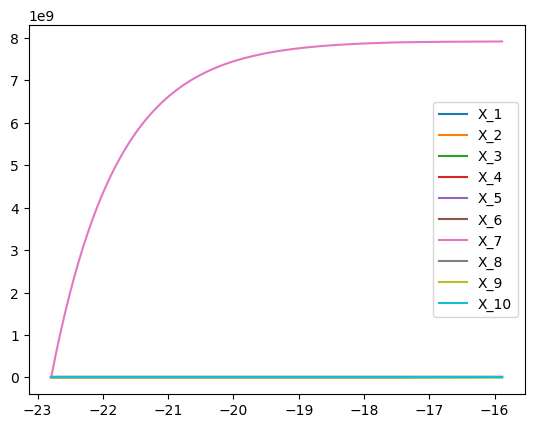

In [18]:
Xs=X-X.mean(0)
Xs=Xs/Xs.std(0)
# lambdas=10**np.linspace(-2,8,100)/Y.std()
lambdas,coeff,_=skl.ElasticNet.path(Xs,Y,l1_ratio=1,n_alphas=100)
pd.DataFrame(data=coeff.T,index=-np.log(lambdas),columns=idx).plot()

# Question 9

In [19]:
College=ISLP.load_data('College')
College.drop('Private',axis=1,inplace=True)
College

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


## A

In [20]:
X_train,X_test,y_train,y_test=skm.train_test_split(College.drop('Apps',axis=1),College["Apps"]
                                                   ,test_size=.25,random_state=0)

## B

In [21]:
X_train.shape

(582, 16)

In [22]:
X=MS(X_train.columns).fit_transform(X_train)
result=sm.OLS(y_train,X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Apps   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     489.0
Date:                Sat, 28 Sep 2024   Prob (F-statistic):          1.96e-318
Time:                        22:15:53   Log-Likelihood:                -4877.1
No. Observations:                 582   AIC:                             9788.
Df Residuals:                     565   BIC:                             9862.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    -443.6005    459.662     -0.965      0.335   -1346.456     459.255
Accept          1.6341      0.046     35.790      0.000       1.544       1.724
Enroll         -1.0592      0.215     -4.937      0.000      -1.481      -0.638
Top10perc      57.8352      6.588      8.779      0.000      44.895      70.776
Top25perc     -18.2284      5.255     -3.469      0.001     -28.550      -7.907
F.Undergrad     0.0885      0.038      2.351      0.019       0.015       0.163
P.Undergrad     0.0635      0.035      1.796      0.073      -0.006       0.133
Outstate       -0.1034      0.021     -4.882      0.000      -0.145      -0.062
Room.Board      0.1550      0.058      2.692      0.007       0.042       0.268
Books          -0.0171      0.267     -0.064      0.949      -0.543       0.508
Personal       -0.0142      0.073     -0.193      0.847      -0.158       0.130
PhD            -8.9675      5.473     -1.639      0.102     -19.717       1.782
Terminal       -0.4193      5.931     -0.071      0.944     -12.069      11.230
S.F.Ratio      12.1401     14.648      0.829      0.408     -16.631      40.911
perc.alumni    -0.7276      4.970     -0.146      0.884     -10.489       9.034
Expend          0.0511      0.014      3.613      0.000       0.023       0.079
Grad.Rate       7.3973      3.551      2.083      0.038       0.423      14.371
==============================================================================
Omnibus:                      347.318   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6256.031
Skew:                           2.263   Prob(JB):                         0.00
Kurtosis:                      18.411   Cond. No.                     1.73e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
#result.predict(X_test)
# X_test1=pd.get_dummies(X_test,drop_first=True,columns=['Private']).set_index('Private_Yes').reset_index()
X_test1=sm.add_constant(X_test).rename(columns={'const':'intercept'})
RSS=np.mean((result.predict(X_test1)-y_test)**2)
RSS,np.sqrt(RSS/(y_test.shape[0]-X_test.shape[1]-1))

(1024413.952793322, 75.86260321301015)

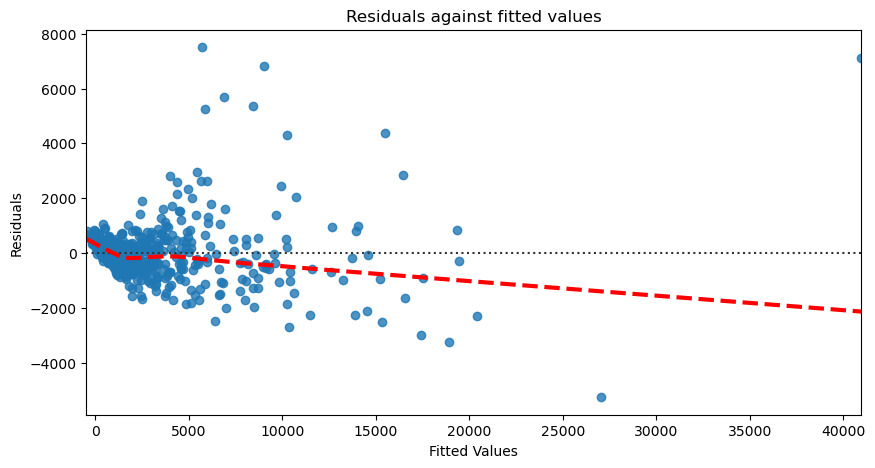

In [24]:
plt.figure(figsize=(10,5))
sns.residplot(x=result.fittedvalues,y=result.resid,lowess=True,
              line_kws={'color':'red','lw':3,'ls' : "--"})
plt.title("Residuals against fitted values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

## C

In [25]:
K=5
lambdas=10**np.linspace(-2,8,100)/y_train.std()
kfold=skm.KFold(shuffle=True,random_state=0)
scaler=StandardScaler()
ridgeCV=skl.ElasticNetCV(l1_ratio=0,alphas=lambdas,cv=kfold)
pipeCV=Pipeline([('scaler',scaler),('ridgeCV',ridgeCV)])
import warnings
with warnings.catch_warnings(action='ignore'):
    pipeCV.fit(X_train,y_train)

In [26]:
RSS=np.mean((ridgeCV.predict(scaler.transform(X_test)) - y_test)**2)
ridgeCV.alpha_,ridgeCV.coef_,ridgeCV.intercept_,RSS,ridgeCV.score(scaler.transform(X_test),y_test)

(2.458783010357005e-06,
 array([ 4.20814097e+03, -1.01866325e+03,  1.02638780e+03, -3.61587336e+02,
         4.46168325e+02,  1.05088612e+02, -4.12317487e+02,  1.67377941e+02,
        -3.00657541e+00, -9.88985509e+00, -1.46896004e+02, -6.16103934e+00,
         4.88060406e+01, -8.80021967e+00,  2.69108675e+02,  1.26613152e+02]),
 3080.6855670103087,
 1024398.9757913487,
 0.9000471905509182)

In [27]:
param_grid = {'ridge__alpha': lambdas}
ridge=skl.ElasticNet(l1_ratio=0,alpha=lambdas[24])
pipeCV=Pipeline([('scaler',scaler),('ridge',ridge)])
grid = skm.GridSearchCV(pipeCV ,param_grid ,cv=kfold ,scoring='neg_mean_squared_error',verbose=0)
with warnings.catch_warnings(action="ignore"):
    grid.fit(X_train,y_train)
grid.best_params_['ridge__alpha'],grid.best_estimator_

(2.458783010357005e-06,
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('ridge', ElasticNet(alpha=2.458783010357005e-06, l1_ratio=0))]))

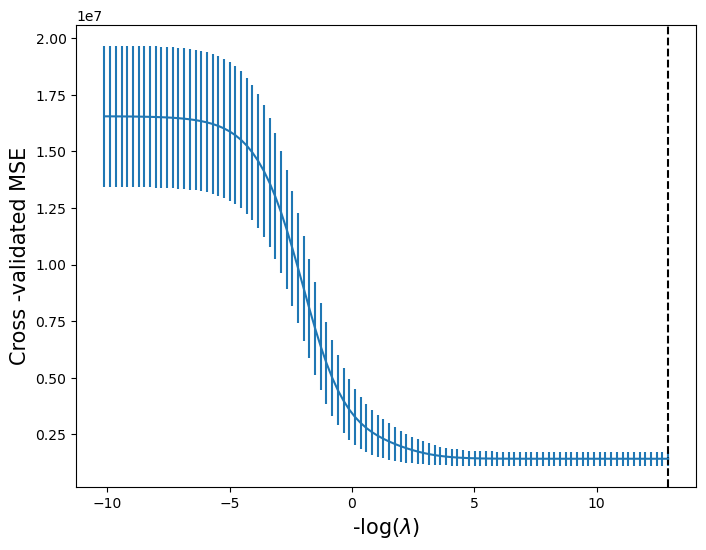

In [28]:
ridge_fig , ax = plt.subplots(figsize =(8 ,6))
ax.errorbar(-np.log(lambdas),-grid.cv_results_['mean_test_score'],yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel(r'-log($\lambda)$', fontsize =15)
ax.axvline(-np.log(grid.best_params_['ridge__alpha']),c='k',ls='--')
ax.set_ylabel('Cross -validated MSE', fontsize =15);

## D

In [29]:
lassoCV=skl.ElasticNetCV(l1_ratio=1,n_alphas=100,cv=kfold)
pipeCV=Pipeline([('scaler',scaler),('lassoCV',lassoCV)])
pipeCV.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lassoCV',
                 ElasticNetCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=1))])

In [30]:
RSS=np.mean((lassoCV.predict(scaler.transform(X_test)) - y_test)**2)
lassoCV.coef_,lassoCV.intercept_,RSS,lassoCV.score(scaler.transform(X_test),y_test)

(array([4152.77300147, -837.85690692,  970.43879715, -313.00741555,
         314.84934455,  103.05920306, -391.43788132,  161.95429141,
          -0.        ,   -4.19681495, -136.92538384,   -4.92102826,
          41.99176562,   -9.21952938,  259.59549361,  112.93809534]),
 3080.6855670103087,
 1013654.5807878076,
 0.9010955442605703)

## E

In [31]:
pca=PCA(n_components=2)
linreg=skl.LinearRegression()
pipe=Pipeline([('scaler', scaler),('pca', pca),('linreg', linreg)])
param_grid = {'pca__n_components': range(1, len(X_train.columns)+1)}
grid=skm.GridSearchCV(pipe,param_grid,cv=kfold,scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 17)},
             scoring='neg_mean_squared_error')

In [32]:
grid.best_estimator_,grid.best_params_,grid.best_score_,grid.best_index_

(Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=16)),
                 ('linreg', LinearRegression())]),
 {'pca__n_components': 16},
 -1422272.4162852508,
 15)

In [33]:
'grid.score return score may be R^2 or may be MSE, depends aonscoring used'
np.mean((grid.predict(X_test)- y_test)**2),grid.score((X_test),y_test)

(1024413.9527933183, -1024413.9527933183)

In [34]:
grid.cv_results_

{'mean_fit_time': array([0.03068457, 0.01411076, 0.01448588, 0.01850252, 0.01610641,
        0.01812644, 0.01610632, 0.02175503, 0.01490679, 0.01448026,
        0.01528635, 0.01650743, 0.02012658, 0.01812482, 0.02861042,
        0.04028916]),
 'std_fit_time': array([1.61740473e-02, 4.19884984e-03, 4.65965185e-03, 8.17325880e-04,
        4.23352595e-03, 3.11676154e-03, 4.22744096e-03, 3.20982626e-03,
        4.33207156e-03, 2.94171769e-03, 3.49380770e-03, 4.48657334e-03,
        1.69508735e-05, 7.09676281e-03, 4.50323131e-03, 2.11373902e-02]),
 'mean_score_time': array([0.01048622, 0.00643821, 0.0036222 , 0.00162377, 0.00804982,
        0.00563493, 0.00804858, 0.00524421, 0.00805902, 0.00602875,
        0.00281749, 0.00885482, 0.00732665, 0.00764108, 0.00805607,
        0.01011167]),
 'std_score_time': array([0.00655135, 0.00447565, 0.00368465, 0.00081192, 0.003114  ,
        0.00389956, 0.0031178 , 0.00394109, 0.00402952, 0.00335756,
        0.00372768, 0.00099396, 0.00380122, 0.002953

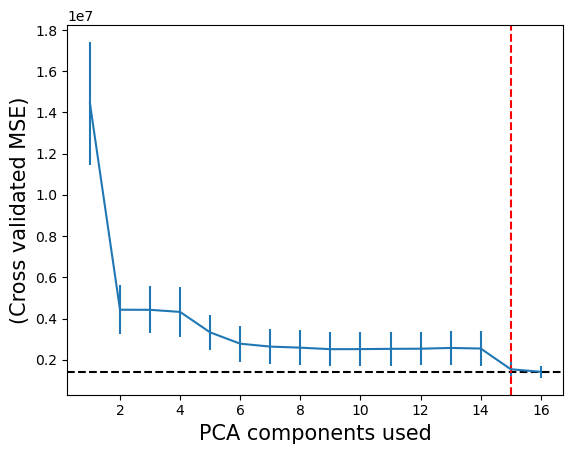

In [35]:
pca_fig,ax=plt.subplots()
ax.errorbar(x=range(1, len(X_train.columns)+1), y=-grid.cv_results_['mean_test_score'],
                    yerr=grid.cv_results_['std_test_score']/np.sqrt(K))
ax.axhline(-grid.best_score_,c='k',ls='--')
ax.axvline(grid.best_index_,c='r',ls='--')
ax.set_xlabel('PCA components used', fontsize =15)
ax.set_ylabel(r'(Cross validated MSE)', fontsize =15);

## F

In [36]:
pls=PLSRegression(n_components=2,scale=True)
param_grid={'n_components':range(1, len(X_train.columns)+1)}
grid=skm.GridSearchCV(pls,param_grid,cv=kfold,scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 17)},
             scoring='neg_mean_squared_error')

In [37]:
grid.best_estimator_,grid.best_params_,grid.best_score_,grid.best_index_

(PLSRegression(n_components=11), {'n_components': 11}, -1411424.7170209032, 10)

In [38]:
RMSE=np.sqrt(np.mean((grid.predict(X_test)-y_test)**2))
RMSE**2,grid.score(X_test,y_test),RMSE

(1019707.4704039907, -1019707.4704039907, 1009.8056597207161)

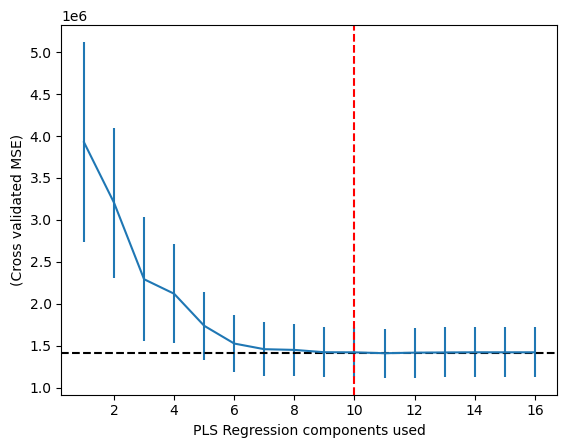

In [39]:
pls_fig,ax=plt.subplots()
ax.errorbar(x=range(1, len(X_train.columns)+1), y=-grid.cv_results_['mean_test_score'],
                    yerr=grid.cv_results_['std_test_score']/np.sqrt(K))
ax.axhline(-grid.best_score_,c='k',ls='--')
ax.axvline(grid.best_index_,c='r',ls='--')
ax.set_xlabel('PLS Regression components used', fontsize =10)
ax.set_ylabel(r'(Cross validated MSE)', fontsize =10);

# Question 10

In [86]:
d={}
for i in range (20):
    seed=np.random.randint(1,10000)
    d[f'X_{i}']=np.random.chisquare(df=seed,size=1000)
df=pd.DataFrame(d)
eps=np.random.normal(size=1000)*100
beta=np.random.randint(-20,20,size=20)
beta[[3,8,11,14,]]=0

In [87]:
beta

array([ -6,   9,  -6,   0,   3,  12, -16,   6,   0,  18, -11,   0,   2,
       -18,   0,  10, -20,  -2, -17, -17])

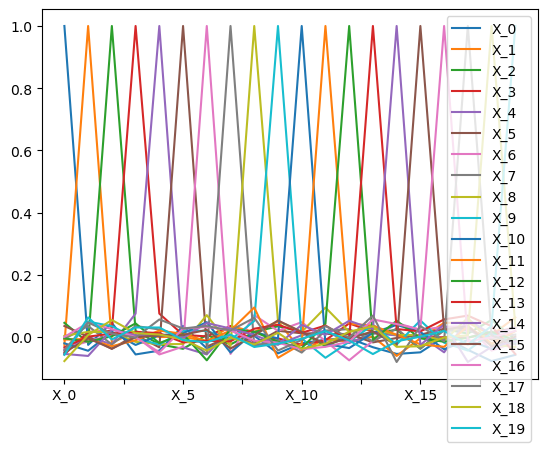

In [88]:
df.corr().plot();

In [89]:
X=np.asarray(df);
B=beta[:,np.newaxis]
Y=X.dot(B)+eps[:,np.newaxis]
df1=pd.concat([df,pd.DataFrame(Y,columns=['Y'])],axis=1)
df1.to_csv('df.csv',header=True,index=False)
df1

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,Y
0,6463.690398,9168.278638,2696.780318,6883.038259,129.661022,5088.600327,1189.098638,4270.543177,6235.878627,478.789763,...,4301.462014,1571.912248,5830.413323,9345.816027,1936.325245,9515.661181,8118.325058,5240.556272,4168.484817,-348334.659126
1,6639.791030,9265.478463,2714.045139,6915.459890,118.359966,4814.780428,1236.638905,4397.800946,5857.893380,394.070940,...,4220.354000,1686.687731,5755.560903,9587.878037,1859.322888,9516.015442,8005.739671,5507.609880,4150.616044,-356991.469771
2,6413.211445,8943.463678,2770.951172,6828.166855,94.991880,5088.300673,1226.610775,4226.732639,5990.559604,495.142298,...,4349.754346,1616.575989,5878.362572,9447.530180,1922.173665,9643.078994,8013.080517,5330.074578,4415.697807,-360920.018542
3,6501.956519,9119.040586,2540.690733,6973.720507,111.871402,4932.837130,1114.407699,4398.839639,5970.049723,490.297416,...,4354.599575,1565.577301,5747.314756,9417.320338,1945.134278,9607.402726,8180.021259,5157.880774,4092.731090,-346285.031920
4,6668.813749,8795.393495,2642.676138,7192.978163,148.785878,4939.842938,1202.769804,4357.559482,6028.522884,478.854008,...,4170.404605,1568.212127,5736.051033,9254.009781,1931.318075,9431.913044,8258.327529,5338.247455,4105.492653,-351816.415813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6383.347393,8939.603335,2643.390094,7043.191176,146.758092,4805.549571,1244.668097,4068.615455,6182.324834,485.220350,...,4349.319079,1559.650177,5781.123811,9552.094875,2056.670186,9368.220571,8278.453637,5243.581580,4207.848913,-351419.628513
996,6584.124285,8991.561733,2774.485940,7071.586993,104.649442,4925.189985,1269.653150,4450.051880,6146.727413,465.795843,...,4488.532011,1509.456446,5798.938598,9471.370488,2075.653161,9620.485071,8324.271215,5252.119934,4124.677949,-354313.873010
997,6401.777804,8931.797684,2580.449539,7093.874101,136.408304,4960.186538,1228.194769,4305.073199,6062.489852,494.563406,...,4509.399296,1539.825740,5753.622440,9346.714659,2016.151587,9727.040712,8083.776193,5157.675667,4180.304737,-352453.144652
998,6597.143997,9158.058130,2633.192028,6958.197003,165.386259,4845.829311,1115.052889,4185.020310,5993.705851,417.194140,...,4264.886613,1569.567489,5774.864745,9154.957534,2043.167088,9531.604455,8188.314890,5188.471807,4202.053891,-350255.511400


In [90]:
X_train,X_test,y_train,y_test=skm.train_test_split(df,df1['Y'],test_size=900)

In [91]:
''' Below cell takes more than 2 hrs to run.. so converted to raw cell
coeff matrix for this case is:
array([ -6,   9,  -6,   0,   3,  12, -16,   6,   0,  18, -11,   0,   2,
       -18,   0,  10, -20,  -2, -17, -17])
load test.csv for result of below cell, valid with above beta coeffs'''

' Below cell takes more than 2 hrs to run.. so converted to raw cell\ncoeff matrix for this case is:\narray([ -6,   9,  -6,   0,   3,  12, -16,   6,   0,  18, -11,   0,   2,\n       -18,   0,  10, -20,  -2, -17, -17])\nload test.csv for result of below cell, valid with above beta coeffs'

In [93]:
result=pd.read_csv('test.csv')#.reindex(index=range(1,21))
result['No. of Variables']=range(1,21)
result.set_index('No. of Variables',inplace=True)
result[:2]

,intercept,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,MSE
No. of Variables,,,,,,,,,,,,,,,,,,,,,
1,-165237.064856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-19.648211,0.0,0.0,0.000000,1.451323e+07
2,-90207.047256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-19.427334,0.0,0.0,-18.359165,1.086389e+07


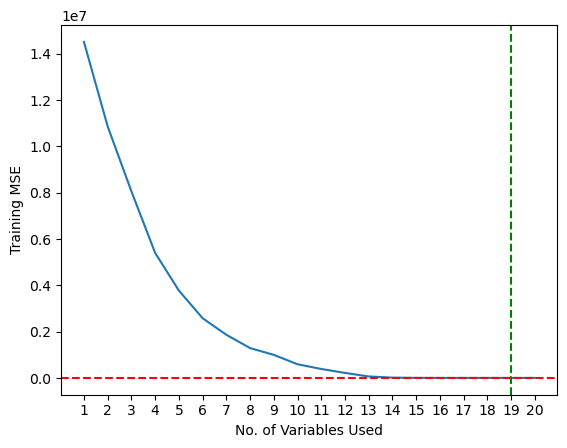

In [138]:
result['MSE'].plot(use_index=True)
plt.xticks(ticks=range(1,21,1))
plt.axvline(np.argmin(np.asarray(result['MSE'])), c='g',ls='--')
plt.axhline(result['MSE'].min(),c='r',ls='--')
plt.xlabel('No. of Variables Used')
plt.ylabel('Training MSE');

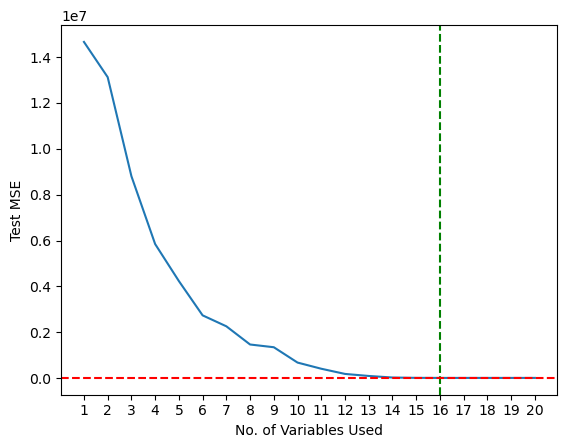

In [137]:
'Calculation of test MSE'
MSE=[]
X_test1=X_test.copy()
X_test1.insert(loc=0,column='intercept',value=1)
for i in range(len(result.index)):
    # coeffs=result.iloc[i].drop(['MSE'])
    MSE.append(np.mean(np.square((X_test1*result.iloc[i].drop(['MSE'])).sum(axis=1)-y_test)))
plt.plot(range(1,21),MSE)
plt.xticks(ticks=range(1,21))
plt.axvline(np.argmin(np.array(MSE))+1,c='g',ls='--')
plt.axhline(min(MSE),c='r',ls='--')
plt.xlabel('No. of Variables Used')
plt.ylabel('Test MSE');

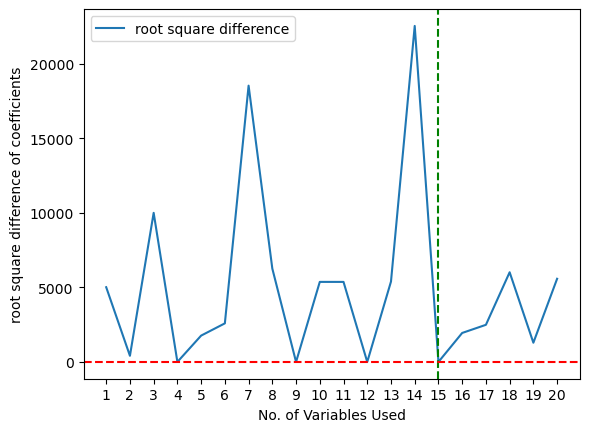

In [141]:
result_array=np.asarray(result.drop(['intercept','MSE'],axis=1))
beta=np.array([ 11,  10,  19,   0,  10,  -1,  19, -14,   0,  -5, -20,   0,  17,
        17,   0,  14,  -9, -18, -10,   0])
beta=beta[:,np.newaxis].T
beta.shape,result_array.shape
root_square_diff=pd.DataFrame(np.sum((result_array-beta)**2,axis=0),index=range(1,21),columns=['root square difference'])
root_square_diff.plot()
plt.xticks(ticks=range(1,21))
plt.axvline(np.argmin(np.asarray(root_square_diff['root square difference']))+1,c='g',ls='--')
plt.axhline(root_square_diff['root square difference'].min(),c='r',ls='--')
plt.xlabel('No. of Variables Used')
plt.ylabel('root square difference of coefficients');

# Question 11

## A

In [101]:
Boston=ISLP.load_data('Boston')
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


In [102]:
X_train=Boston.drop('crim',axis=1)
y_train=Boston['crim']

In [103]:
lin_reg=skl.LinearRegression()
d=skm.cross_validate(lin_reg,X_train,y_train,scoring='neg_mean_squared_error')
skm.cross_val_predict(lin_reg,X_train,y_train)
# -lin_cv.mean()

array([-7.47401704e-01, -9.03683107e-01, -4.68579404e+00, -5.24077131e+00,
       -5.38547479e+00, -3.87956775e+00,  9.42656315e-01,  9.65639761e-01,
        4.77068773e+00,  1.76371925e+00,  3.75072601e+00,  1.54568712e+00,
        1.41639467e+00, -2.16570156e+00, -7.16058493e-01, -1.91921675e+00,
       -3.27389609e+00,  2.29764567e-01, -1.22248963e+00, -2.42087514e-01,
        2.59861548e+00, -6.11336160e-02,  1.88202287e+00,  2.04435070e+00,
        9.09240064e-01,  1.02702822e+00,  4.79198013e-02,  1.18322172e+00,
       -5.94103842e-02, -5.87845504e-01,  2.61218385e+00,  1.07882570e+00,
        3.45973083e+00,  2.36145740e+00,  2.80475566e+00,  1.98122328e+00,
        1.81880991e+00,  3.52309741e-01, -3.41045347e-01,  6.77438734e-01,
       -5.28001597e-01, -3.43248775e+00, -3.22131631e+00, -2.81627186e+00,
       -1.29544716e+00, -3.56858461e-01,  9.91567673e-02,  1.78286588e+00,
        3.71481629e+00, -2.08655463e-01,  9.91554353e-01,  5.02065154e-01,
       -1.54558243e+00, -

In [106]:
predictors=Boston.drop('crim',axis=1).columns
Best_model=[]
MSE=float('inf')
for i in range(1,len(predictors)+1):
    MSE=float('inf')
    print(i)
    for combinations in itertools.combinations(predictors,i):
        x_train=X_train[list(combinations)]
        lin_reg=skl.LinearRegression()
        mse=-skm.cross_val_score(lin_reg,x_train,y_train,scoring='neg_mean_squared_error').mean()
        if mse<MSE:
            MSE=mse
            Z=[mse]
    Best_model.append(Z)
best_subsets=pd.DataFrame(Best_model,
                          columns=['MSE'])
best_subsets.to_csv('test1.csv',header=True,index=False)

1
2
3
4
5
6
7
8
9
10
11
12


In [244]:
best_subsets=best_subsets.reindex(index=range(1,12))#['MSE'].min()
np.where(np.array(Best_model)==np.array(Best_model).min())[0]

array([6], dtype=int64)

Text(0, 0.5, 'MSE')

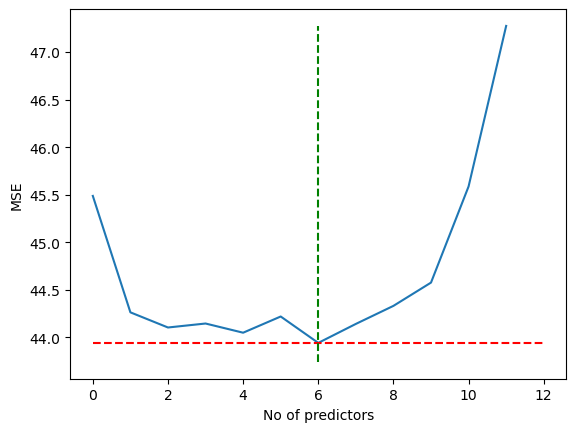

In [252]:
best_subsets=pd.DataFrame(Best_model,
                          columns=['MSE'])
best_subsets.plot(legend=False)
plt.xlabel("No of predictors")
plt.hlines(np.array(Best_model).min(),xmin=0,xmax=12,colors='r',linestyles='--')
plt.vlines(np.where(np.array(Best_model)==np.array(Best_model).min())[0][0],
          ymin=np.array(Best_model).min()-0.2,ymax=np.array(Best_model).max(),colors='g',linestyles='--')
plt.ylabel("MSE")

In [114]:
scaler=StandardScaler()
lassoCV=skl.ElasticNetCV(l1_ratio=1,n_alphas=100)
pipeCV=Pipeline([('scaler',scaler),('lassoCV',lassoCV)])
pipeCV.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lassoCV', ElasticNetCV(l1_ratio=1))])

In [147]:
lassoCV.coef_,lassoCV.alphas_,lassoCV.mse_path_.mean(1)

(array([ 0.        , -0.        , -0.        ,  0.        ,  0.        ,
         0.        , -0.19791302,  4.22736516,  0.        , -0.        ,
         0.92844734, -0.63546043]),
 array([5.37499158, 5.01273514, 4.67489356, 4.35982138, 4.06598402,
        3.7919503 , 3.53638554, 3.29804499, 3.0757678 , 2.86847134,
        2.67514597, 2.49485009, 2.32670554, 2.16989338, 2.02364983,
        1.8872626 , 1.76006742, 1.64144476, 1.53081688, 1.42764495,
        1.33142646, 1.24169277, 1.15800683, 1.07996105, 1.00717529,
        0.93929504, 0.8759897 , 0.81695093, 0.76189117, 0.71054225,
        0.66265408, 0.61799342, 0.57634273, 0.53749916, 0.50127351,
        0.46748936, 0.43598214, 0.4065984 , 0.37919503, 0.35363855,
        0.3298045 , 0.30757678, 0.28684713, 0.2675146 , 0.24948501,
        0.23267055, 0.21698934, 0.20236498, 0.18872626, 0.17600674,
        0.16414448, 0.15308169, 0.14276449, 0.13314265, 0.12416928,
        0.11580068, 0.1079961 , 0.10071753, 0.0939295 , 0.08759897,
  

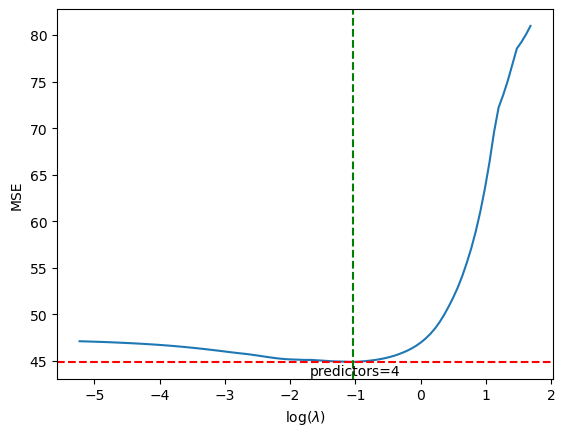

In [255]:
fig,ax=plt.subplots()
ax.plot(np.log(lassoCV.alphas_),lassoCV.mse_path_.mean(1))
ax.axvline(np.log(lassoCV.alpha_),c='g',ls='--')
ax.axhline(lassoCV.mse_path_.mean(1).min(),c='r',ls='--')
plt.xlabel(r"log($\lambda$)")
plt.ylabel("MSE")
ax.text(-1.7,43.5,s=f'predictors={np.sum(lassoCV.coef_ != 0)}');

In [187]:
lambdas=10**(np.linspace(-2,6,100))/y_train.std()
# Xs=X_train-X_train.mean(0)
# Xs=Xs/X_train.std(0)
ridgeCV=skl.ElasticNetCV(l1_ratio=0,alphas=lambdas,verbose=0)
pipeCV=Pipeline([('scaler',scaler),('ridgeCV',ridgeCV)])
with warnings.catch_warnings(action="ignore"):
    pipeCV.fit(X_train,y_train)
pipeCV.named_steps

{'scaler': StandardScaler(),
 'ridgeCV': ElasticNetCV(alphas=array([1.16258182e-03, 1.40033392e-03, 1.68670717e-03, 2.03164476e-03,
        2.44712330e-03, 2.94756868e-03, 3.55035691e-03, 4.27641747e-03,
        5.15095998e-03, 6.20434953e-03, 7.47316097e-03, 9.00144885e-03,
        1.08422770e-02, 1.30595610e-02, 1.57302875e-02, 1.89471870e-02,
        2.28219538e-02, 2.74891241e-02, 3.31107474e-02, 3.98820124e-02,
        4.80380251e-02, 5.786197...
        1.61004372e+03, 1.93930337e+03, 2.33589777e+03, 2.81359713e+03,
        3.38898771e+03, 4.08204769e+03, 4.91684090e+03, 5.92235227e+03,
        7.13349427e+03, 8.59231910e+03, 1.03494788e+04, 1.24659838e+04,
        1.50153217e+04, 1.80860081e+04, 2.17846608e+04, 2.62397010e+04,
        3.16058128e+04, 3.80693134e+04, 4.58546228e+04, 5.52320554e+04,
        6.65272063e+04, 8.01322555e+04, 9.65195855e+04, 1.16258182e+05]),
              l1_ratio=0)}

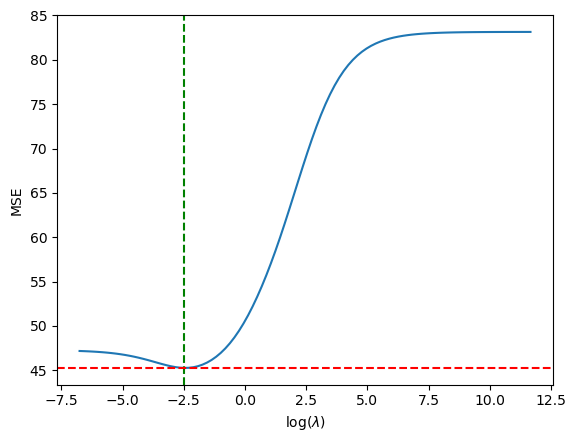

In [203]:
tuned_ridge=pipeCV.named_steps['ridgeCV']
fig,ax=plt.subplots()
ax.plot(np.log(tuned_ridge.alphas_),tuned_ridge.mse_path_.mean(1))
ax.axvline(np.log(tuned_ridge.alpha_),c='g',ls='--')
ax.axhline(tuned_ridge.mse_path_.mean(1).min(),c='r',ls='--')
plt.xlabel(r"log($\lambda$)")
plt.ylabel("MSE");

In [205]:
pca=PCA(n_components=2)
lin_reg=skl.LinearRegression()
scaler=StandardScaler()
kfold=skm.KFold(shuffle=True,random_state=0)
pipe=Pipeline([('scaler',scaler),('pca',pca),('lin_reg',lin_reg)])
param_grid={'pca__n_components':range(1,len(X_train.columns)+1)}
grid=skm.GridSearchCV(pipe,param_grid,cv=kfold,scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('lin_reg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 13)},
             scoring='neg_mean_squared_error')

In [209]:
grid.cv_results_,grid.best_params_,grid.best_score_

({'mean_fit_time': array([0.02447934, 0.01249967, 0.        , 0.01692882, 0.00624962,
         0.00443087, 0.01562448, 0.01047235, 0.01046777, 0.01205459,
         0.01248455, 0.01207423]),
  'std_fit_time': array([2.34303564e-02, 6.24983323e-03, 0.00000000e+00, 2.60191581e-03,
         7.65418824e-03, 6.14613541e-03, 8.03580262e-07, 8.53874290e-04,
         8.07420716e-04, 4.01299213e-03, 3.88094347e-03, 4.03813699e-03]),
  'mean_score_time': array([0.00625095, 0.        , 0.00312414, 0.        , 0.        ,
         0.        , 0.        , 0.00362124, 0.00402527, 0.00562844,
         0.00804386, 0.00402336]),
  'std_score_time': array([0.00765582, 0.        , 0.00624828, 0.        , 0.        ,
         0.        , 0.        , 0.00367588, 0.0042186 , 0.00465511,
         0.00402194, 0.00421876]),
  'param_pca__n_components': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
               mask=[False, False, False, False, False, False, False, False,
                     Fals

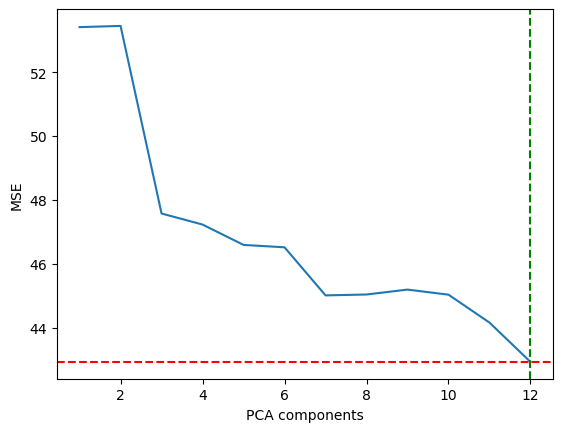

In [213]:
n_comp = param_grid['pca__n_components']
fig,ax=plt.subplots()
ax.plot(n_comp,-grid.cv_results_['mean_test_score'])
ax.axhline(-grid.best_score_,c='r',ls='--')
ax.axvline(grid.best_params_['pca__n_components'],c='g',ls='--')
ax.set_xlabel("PCA components")
ax.set_ylabel("MSE");

In [215]:
pls=PLSRegression()
param_grid = {'n_components':range(1,len(X_train.columns)+1)}
grid=skm.GridSearchCV(pls,param_grid,cv=kfold,scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 13)},
             scoring='neg_mean_squared_error')

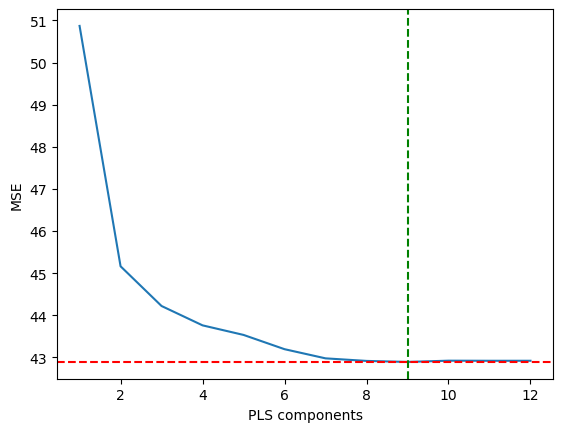

In [216]:
n_comp = param_grid['n_components']
fig,ax=plt.subplots()
ax.plot(n_comp,-grid.cv_results_['mean_test_score'])
ax.axhline(-grid.best_score_,c='r',ls='--')
ax.axvline(grid.best_params_['n_components'],c='g',ls='--')
ax.set_xlabel("PLS components")
ax.set_ylabel("MSE");